# Recommender Systems

Recommendation System belongs to the class of Information Retrieval, Data Mining and Machine Learning. Recommender systems play a major role in today's ecommerce industry. Recommender systems recommend items to users such as books, movies, videos, electronic products and many other products in general. Recommender systems help the users to get personalized recommendations, helps users to take correct decisions in their online transactions, increase sales and redefine the users web browsing experience, retain the customers, enhance their shopping experience. Information overload problem is solved by search engines, but they do not provide personalization of data. Recommendation engines provide personalization. There are different type of recommender systems such as content-based, collaborative filtering, hybrid recommender system, demographic and keyword based recommender system. Variety of algorithms are used by various researchers in each type of recommendation system. Lot of work has been done on this topic, still it is a very favourite topic among data scientists. It also comes under the domain of data Science

In [124]:
import pandas as pd
import numpy as np
import random
from tqdm.notebook import tqdm
from gensim.models import Word2Vec 
import matplotlib.pyplot as plt
import seaborn as sns
import os
import tensorflow as tf
%matplotlib inline
from IPython.display import display

import warnings
# supress warnings
warnings.filterwarnings('ignore')
#increase the size of seaborn plots
sns.set(rc={'figure.figsize':(11.7,8.27)})

## Reading and Preprocessing 
We use the movieLens dataset 
The dataset is divided into 2 files:
* movies.csv
* ratings.csv

The *movies.csv* contains the **movieId**, **title**, and **genres** of the movies

The *ratings.csv* contains the **userId**,	**movieId**, **rating**, and **timestamp** of the ratings

In [125]:
# Reading the data using pandas
df_movies = pd.read_csv('movies.csv')
df_ratings = pd.read_csv('ratings.csv')

In [126]:
#Visualizing the movies dataset
movies = df_movies
df_movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [127]:
#Visualizing the ratings dataset
df_ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


### Merging the dataset for greater insight
There are a lot of users in the dataset so to get an overall impression of the movies, we take the mean of the ratings for a particular movie. The dataframes are joined using a full outer join

In [128]:
ratings = df_ratings.groupby('movieId', as_index=False)['rating'].mean()
merged_df = pd.merge(movies, ratings, how='outer')
merged_df.head()

,movieId,title,genres,rating
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,3.920930
1,2,Jumanji (1995),Adventure|Children|Fantasy,3.431818
2,3,Grumpier Old Men (1995),Comedy|Romance,3.259615
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,2.357143
4,5,Father of the Bride Part II (1995),Comedy,3.071429


# Visualizations for the Dataset
Visualization is one of the most important aspect of data mining. It helps us get insights from the data that would otherwise be unexplored. We have explored the dataset to check how the data is distributed, which genre has what average rating, whats the count of ratings after we ceil the average ratings and so on 

Text(0, 0.5, 'MovieId')

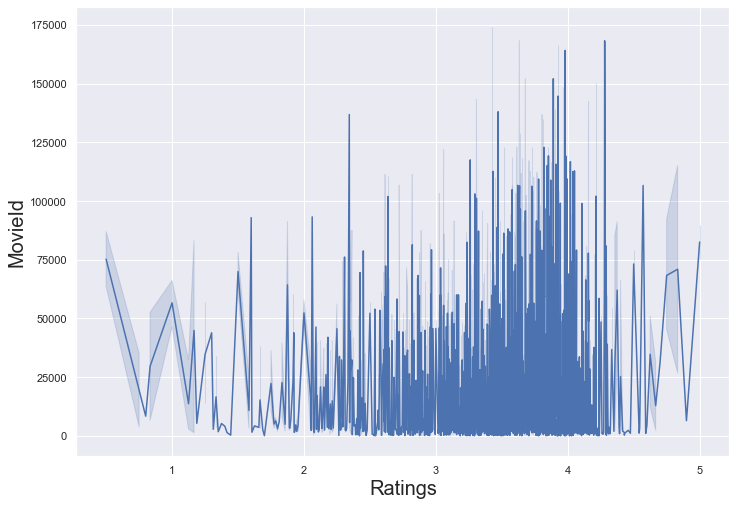

In [129]:
p = sns.lineplot(x=ratings.rating.values, y=ratings.movieId.values)
p.set_xlabel("Ratings", fontsize = 20)
p.set_ylabel("MovieId", fontsize = 20)

This graph shows us the plot of **movieId** against **average rating**

From the graph its visible that most of the rating are concentrated in the range 2-4 with a peak density around 4

Text(0, 0.5, 'Frequency')

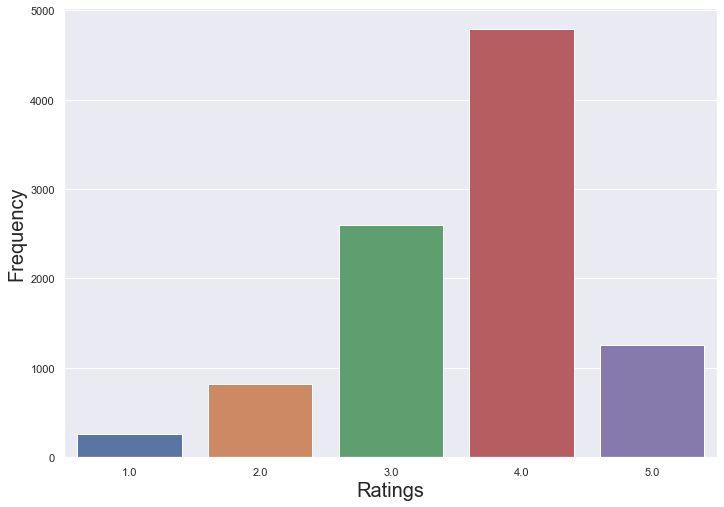

In [130]:
ratings_ = ratings
ratings_['rating'] = np.ceil(ratings_.rating.values)
r = sns.countplot(x=ratings_.rating.values)
r.set_xlabel("Ratings", fontsize = 20)
r.set_ylabel("Frequency", fontsize = 20)

This graph compares the distribution of data when its ceiled, ie it smoothens down the previous graph to give us a better overview

It plots the **ratings** against their **frequency** in the dataset

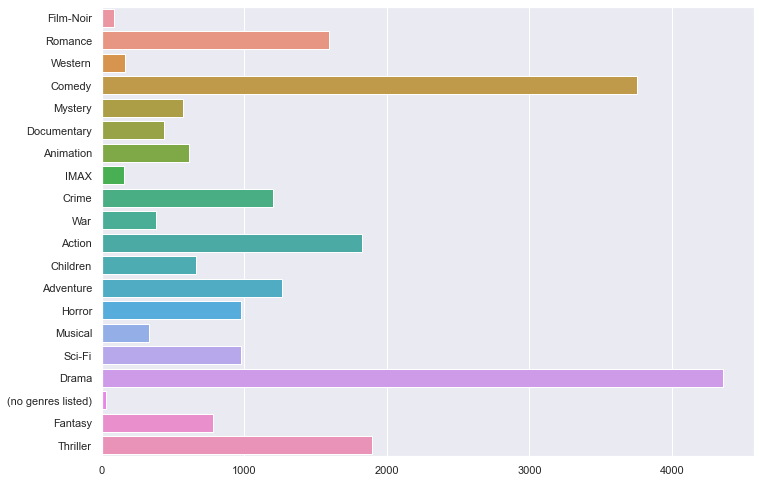

In [131]:
# The data 
genres = df_movies['genres'].apply(lambda x: (x.split("|"))).to_list()
result = {x for l in genres for x in l}
result = dict.fromkeys(result, 0)
for genre in genres:
    for g in genre:
        result[g]+=1
ax = sns.barplot(y=list(result.keys()), x=list(result.values()))


In this barplot, we check the no of movies in each genre. From this we can easily infer that **Drama** and **comedy** are the most popular genres followed by  **Thriller**, **Action**, and **Romance**

In [132]:
genres_set = list({x for l in genres for x in l})
def extractDigits(lst):
    return list(map(lambda el:[el], lst))
genres_set = extractDigits(genres_set)
for i in genres_set:
    i.append(0)
    i.append(0)    
merged_df['genres'] = merged_df['genres'].apply(lambda x: (x.split("|"))).to_list()
merged_df.dropna(inplace=True)
merged_df.head()

,movieId,title,genres,rating
0,1,Toy Story (1995),"[Adventure, Animation, Children, Comedy, Fantasy]",3.920930
1,2,Jumanji (1995),"[Adventure, Children, Fantasy]",3.431818
2,3,Grumpier Old Men (1995),"[Comedy, Romance]",3.259615
3,4,Waiting to Exhale (1995),"[Comedy, Drama, Romance]",2.357143
4,5,Father of the Bride Part II (1995),[Comedy],3.071429


From the merged df, we find the avereage rating of each genre and plot it to find if there is any global trend between ratings and genres. 

In [133]:
# Making a list of lists to store the genre the no of votes and the total ratings
for row, rating in zip(merged_df.genres, merged_df.rating):
    for genre in row:
        for g in range(len(genres_set)):
            if genres_set[g][0] == genre:
                try:
                    genres_set[g][1]+=round(rating,2)
                    genres_set[g][2]+=1
                except:
                    pass   

<AxesSubplot:>

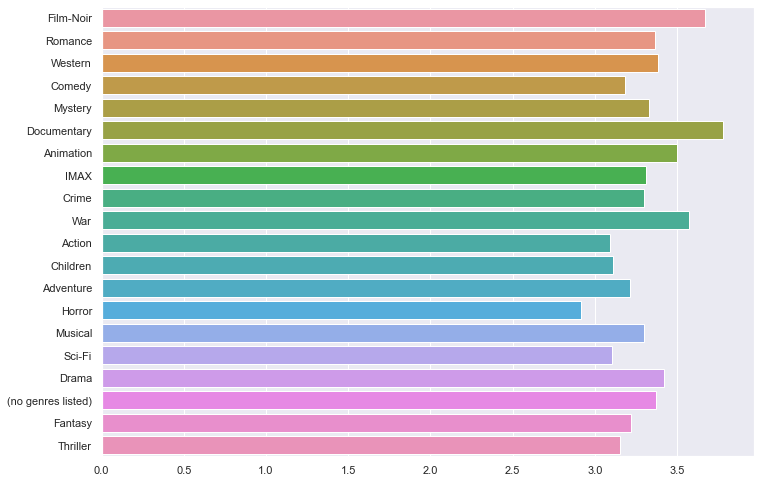

In [134]:
# to find the average rating per genre, the sum of ratings is divided by the no of ratings
ratings_per_genre = []
genres
for i in genres_set:
    ratings_per_genre.append(i[1]/i[2])
genres = list({x for l in genres for x in l})
sns.barplot(x=ratings_per_genre, y=genres)

**Documentary** has the highest ratings followed by **Film Noir** and **War**. However no genre stands out which means the data is well distributed and unbiased.

# Matrix Factorization

In [135]:
df_ratings_np = df_ratings.values
unique_users = np.unique(df_ratings_np.T[0]).tolist()
unique_movies = np.unique(df_ratings_np.T[1]).tolist()
# find the dimensions of UI_matrix
UI_matrix = np.zeros((len(unique_users), len(unique_movies)))
for row in tqdm(df_ratings_np):
  UI_matrix[unique_users.index(row[0])][unique_movies.index(row[1])] = int(row[2])

  0%|          | 0/100836 [00:00<?, ?it/s]

In [136]:
UI_matrix.shape

(610, 9724)

In [137]:
# Users X Movies
UI_matrix[:10][:10]

array([[4., 0., 4., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 4., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [138]:
num_users, num_movies = UI_matrix.shape[0], UI_matrix.shape[1]

In [139]:
# Defining a keras model for matrix factorization

def get_matrix_factorization_model(num_users, num_movies):
  input_user = tf.keras.layers.Input(shape=(1,))
  input_item = tf.keras.layers.Input(shape=(1,))

  user_embeddings = tf.keras.layers.Embedding(num_users, 32, input_length=1)(input_user)
  item_embeddings = tf.keras.layers.Embedding(num_movies, 32, input_length=1)(input_item)

  user_model = tf.keras.Model(inputs=input_user, outputs=user_embeddings)
  item_model = tf.keras.Model(inputs=input_item, outputs=item_embeddings)

  predicted_rating =  tf.keras.layers.Multiply()([user_model.output, item_model.output])
  predicted_rating = tf.reduce_sum(predicted_rating, axis=-1)

  return tf.keras.Model(inputs=[user_model.input, item_model.input], outputs=predicted_rating)

In [140]:
# Defining the loss function for the model
def loss_mf(y_true, y_pred):
  pred = tf.where(y_true>0, y_pred, y_true)
  difference = tf.abs(y_true - pred)
  return tf.reduce_mean(difference, axis=-1)  # Note the `axis=-1`

In [141]:
def get_trainable_model(num_users, num_movies):
  model = get_matrix_factorization_model(num_users, num_movies)
  model.compile(optimizer="Adam", loss=loss_mf)
  return model

In [142]:
model = get_trainable_model(num_users, num_movies)

In [143]:
def get_training_data(UI_matrix, split=0.8):
  np.random.seed(0)
  positive_indices = np.argwhere(UI_matrix>0)
  positive_samples = np.array([[index[0], index[1], UI_matrix[index[0]][index[1]]] for index in tqdm(positive_indices, desc="Extracting positive samples")])
  negative_indices = np.argwhere(UI_matrix==0)
  indexes = np.random.choice(np.arange(len(negative_indices)), len(positive_samples))
  negative_indices = negative_indices[indexes]
  negative_samples = np.array([[index[0], index[1], UI_matrix[index[0]][index[1]]] for index in tqdm(negative_indices, desc="Extracting negative samples")])
  samples = np.concatenate((positive_samples, negative_samples), axis=0)
  np.random.shuffle(samples)
  return samples[:int(len(samples)*split)], samples[int(len(samples)*split):]

In [144]:
training_data, validating_data = get_training_data(UI_matrix)

Extracting positive samples:   0%|          | 0/99466 [00:00<?, ?it/s]

Extracting negative samples:   0%|          | 0/99466 [00:00<?, ?it/s]

In [145]:
training_data

array([[4.700e+02, 7.110e+03, 0.000e+00],
       [8.800e+01, 9.247e+03, 4.000e+00],
       [9.400e+01, 3.677e+03, 5.000e+00],
       ...,
       [1.570e+02, 6.955e+03, 4.000e+00],
       [1.420e+02, 6.036e+03, 2.000e+00],
       [5.490e+02, 1.510e+02, 0.000e+00]])

In [146]:
model.summary()

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 1, 32)        19520       input_3[0][0]                    
__________________________________________________________________________________________________
embedding_3 (Embedding)         (None, 1, 32)        311168      input_4[0][0]                    
____________________________________________________________________________________________

In [147]:
model.fit(x=[training_data.T[0], training_data.T[1]], y=training_data.T[2], validation_data=([validating_data.T[0], validating_data.T[1]], validating_data.T[2]), epochs=2)

Epoch 1/2
4974/4974 [==============================] - 18s 4ms/step - loss: 1.1420 - val_loss: 0.5845
Epoch 2/2
4974/4974 [==============================] - 16s 3ms/step - loss: 0.4731 - val_loss: 0.4483


In [148]:
x=[training_data.T[0], training_data.T[1]]
x

[array([470.,  88.,  94., ..., 157., 142., 549.]),
 array([7110., 9247., 3677., ..., 6955., 6036.,  151.])]

In [149]:
y = training_data.T[2]
y

array([0., 4., 5., ..., 4., 2., 0.])

In [150]:
model.predict(x=[np.array([470, 88]), np.array([7110, 9247])])

array([[0.7479126],
       [0.7022549]], dtype=float32)

In [151]:
np_movies = df_movies.values
movies = {int(row[0]):row[1] for row in np_movies}
movies

{1: 'Toy Story (1995)',
 2: 'Jumanji (1995)',
 3: 'Grumpier Old Men (1995)',
 4: 'Waiting to Exhale (1995)',
 5: 'Father of the Bride Part II (1995)',
 6: 'Heat (1995)',
 7: 'Sabrina (1995)',
 8: 'Tom and Huck (1995)',
 9: 'Sudden Death (1995)',
 10: 'GoldenEye (1995)',
 11: 'American President, The (1995)',
 12: 'Dracula: Dead and Loving It (1995)',
 13: 'Balto (1995)',
 14: 'Nixon (1995)',
 15: 'Cutthroat Island (1995)',
 16: 'Casino (1995)',
 17: 'Sense and Sensibility (1995)',
 18: 'Four Rooms (1995)',
 19: 'Ace Ventura: When Nature Calls (1995)',
 20: 'Money Train (1995)',
 21: 'Get Shorty (1995)',
 22: 'Copycat (1995)',
 23: 'Assassins (1995)',
 24: 'Powder (1995)',
 25: 'Leaving Las Vegas (1995)',
 26: 'Othello (1995)',
 27: 'Now and Then (1995)',
 28: 'Persuasion (1995)',
 29: 'City of Lost Children, The (Cité des enfants perdus, La) (1995)',
 30: 'Shanghai Triad (Yao a yao yao dao waipo qiao) (1995)',
 31: 'Dangerous Minds (1995)',
 32: 'Twelve Monkeys (a.k.a. 12 Monkeys) (199

In [152]:
def complete_prediction(user_id, UI_matrix, movies, limit=5):
  uid = unique_users.index(user_id)
  negative_indices = np.argwhere(UI_matrix[int(uid)]==0).flatten()
  predicted_ratings_unwatched = np.round(model.predict(x=[np.array([uid]*len(negative_indices)), negative_indices]).flatten())
  predicted_ratings_unwatched = np.where(predicted_ratings_unwatched>=1, predicted_ratings_unwatched, 1)
  predicted_ratings_unwatched = np.where(predicted_ratings_unwatched<=5, predicted_ratings_unwatched, 5)
  movie_ids = np.array([movies[int(unique_movies[i])] for i in negative_indices])
  sorted_indices = np.argsort(predicted_ratings_unwatched)[::-1]
  predicted_ratings_unwatched = predicted_ratings_unwatched[sorted_indices]
  movie_ids = movie_ids[sorted_indices]
  user_recommendation = [{key:rating} for key, rating in zip(movie_ids[:limit], predicted_ratings_unwatched[:limit])]
  positive_indices = np.argwhere(UI_matrix[int(uid)]>0).flatten()
  ratings = UI_matrix[int(uid)][positive_indices]
  movie_ids = np.array([movies[int(unique_movies[i])] for i in positive_indices])
  sorted_indices = np.argsort(ratings)[::-1]
  ratings = ratings[sorted_indices]
  movie_ids = movie_ids[sorted_indices]
  user_watch_history= [{key:rating} for key, rating in zip(movie_ids[:limit], ratings[:limit])]
  return user_recommendation, user_watch_history

In [153]:
complete_prediction(3, UI_matrix, movies)

([{'Toy Story (1995)': 2.0},
  {"Ocean's Eleven (2001)": 2.0},
  {'King Kong (1933)': 2.0},
  {'Vanilla Sky (2001)': 2.0},
  {"Amelie (Fabuleux destin d'Amélie Poulain, Le) (2001)": 2.0}],
 [{'Troll 2 (1990)': 5.0},
  {'Galaxy of Terror (Quest) (1981)': 5.0},
  {'Saturn 3 (1980)': 5.0},
  {'Road Warrior, The (Mad Max 2) (1981)': 5.0},
  {'Hangar 18 (1980)': 5.0}])

In [154]:
complete_prediction(5, UI_matrix, movies)

([{'Importance of Being Earnest, The (2002)': 4.0},
  {'Magnificent Seven, The (1960)': 4.0},
  {'All About Eve (1950)': 4.0},
  {'Game, The (1997)': 4.0},
  {'Rebecca (1940)': 4.0}],
 [{'Once Were Warriors (1994)': 5.0},
  {'Pinocchio (1940)': 5.0},
  {'Beauty and the Beast (1991)': 5.0},
  {'Snow White and the Seven Dwarfs (1937)': 5.0},
  {'Pulp Fiction (1994)': 5.0}])

# Clustering

In [155]:
from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors

In [156]:
final_dataset = df_ratings.pivot(index='movieId',columns='userId',values='rating')
final_dataset.fillna(0,inplace=True)
final_dataset.head()

userId,1,2,3,4,5,6,7,8,9,10,...,601,602,603,604,605,606,607,608,609,610
movieId,,,,,,,,,,,,,,,,,,,,,
1,4.0,0.0,0.0,0.0,4.0,0.0,4.5,0.0,0.0,0.0,...,4.0,0.0,4.0,3.0,4.0,2.5,4.0,2.5,3.0,5.0
2,0.0,0.0,0.0,0.0,0.0,4.0,0.0,4.0,0.0,0.0,...,0.0,4.0,0.0,5.0,3.5,0.0,0.0,2.0,0.0,0.0
3,4.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0


In [157]:
no_user_voted = df_ratings.groupby('movieId')['rating'].agg('count')
no_movies_voted = df_ratings.groupby('userId')['rating'].agg('count')
display(no_user_voted.head())
display(no_movies_voted.head())

movieId
1    215
2    110
3     52
4      7
5     49
Name: rating, dtype: int64

userId
1    232
2     29
3     39
4    216
5     44
Name: rating, dtype: int64

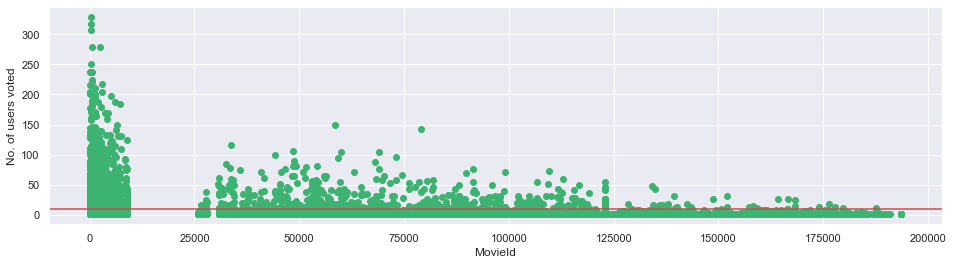

In [158]:
f,ax = plt.subplots(1,1,figsize=(16,4))
# ratings['rating'].plot(kind='hist')
plt.scatter(no_user_voted.index,no_user_voted,color='mediumseagreen')
plt.axhline(y=10,color='r')
plt.xlabel('MovieId')
plt.ylabel('No. of users voted')
plt.show()

This graph plots the movieIds against how many users voted for the movie ID, A higher peak means the movie is popular and likely to be recommended. We take the threshold as 10 ie for the movie to be considered, it has to have atleast 10 votes

In [159]:
final_dataset = final_dataset.loc[no_user_voted[no_user_voted > 10].index,:]

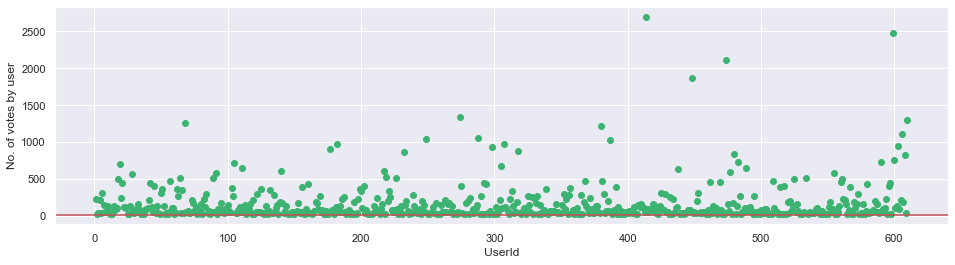

In [160]:
f,ax = plt.subplots(1,1,figsize=(16,4))
plt.scatter(no_movies_voted.index,no_movies_voted,color='mediumseagreen')
plt.axhline(y=10,color='r')
plt.xlabel('UserId')
plt.ylabel('No. of votes by user')
plt.show()

This graph plots the UserIds against how many votes they cast, A higher peak means the user has reviewed many movies. We take the threshold as 10 ie for the user to be considered, they need to vote atleast 10 movies.

In [161]:
final_dataset=final_dataset.loc[:,no_movies_voted[no_movies_voted > 10].index]
final_dataset

userId,1,2,3,4,5,6,7,8,9,10,...,601,602,603,604,605,606,607,608,609,610
movieId,,,,,,,,,,,,,,,,,,,,,
1,4.0,0.0,0.0,0.0,4.0,0.0,4.5,0.0,0.0,0.0,...,4.0,0.0,4.0,3.0,4.0,2.5,4.0,2.5,3.0,5.0
2,0.0,0.0,0.0,0.0,0.0,4.0,0.0,4.0,0.0,0.0,...,0.0,4.0,0.0,5.0,3.5,0.0,0.0,2.0,0.0,0.0
3,4.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0
6,4.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,...,0.0,3.0,4.0,3.0,0.0,0.0,0.0,0.0,0.0,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
174055,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
176371,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
177765,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,4.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


As the matrix is mostly filled with 0s, a sparse matrix is used to represent the data

In [162]:
csr_data = csr_matrix(final_dataset.values)
final_dataset.reset_index(inplace=True)

In [163]:
# Defining the knn Model
knn = NearestNeighbors(metric='cosine', algorithm='brute', n_neighbors=20, n_jobs=-1)
knn.fit(csr_data)

NearestNeighbors(algorithm='brute', metric='cosine', n_jobs=-1, n_neighbors=20)

The Clustering algorithm finds the users who have watched the movie, it then compares the users based on their movies and calculates a score for each movie. ie the distance between the user

In [164]:
def get_movie_recommendation(movie_name, n_movies_to_reccomend = 5):
    movie_list = df_movies[df_movies['title'].str.contains(movie_name)]  
    if len(movie_list):        
        movie_idx= movie_list.iloc[0]['movieId']
        movie_idx = final_dataset[final_dataset['movieId'] == movie_idx].index[0]
        
        distances , indices = knn.kneighbors(csr_data[movie_idx],n_neighbors=n_movies_to_reccomend+1)
        rec_movie_indices = sorted(list(zip(indices.squeeze().tolist(),distances.squeeze().tolist())),\
                               key=lambda x: x[1])[:0:-1]
        print(rec_movie_indices)
        
        recommend_frame = []
        
        for val in rec_movie_indices:
            movie_idx = final_dataset.iloc[val[0]]['movieId']
            idx = df_movies[df_movies['movieId'] == movie_idx].index
            recommend_frame.append({'Title':df_movies.iloc[idx]['title'].values[0],'Distance':val[1]})
        df = pd.DataFrame(recommend_frame,index=range(1,n_movies_to_reccomend+1))
        return df
    
    else:
        
        return "No movies found. Please check your input"

In [165]:
get_movie_recommendation('Iron Man', 5)

[(1896, 0.3757322316601438), (1907, 0.35801447096159067), (1961, 0.3413244923996469), (1830, 0.3322251199632066), (1816, 0.32946219051576764)]


,Title,Distance
1,Avatar (2009),0.375732
2,Iron Man 2 (2010),0.358014
3,"Avengers, The (2012)",0.341324
4,WALL·E (2008),0.332225
5,"Dark Knight, The (2008)",0.329462


In [166]:
get_movie_recommendation('Toy Story', 5)

[(169, 0.4529040920598262), (124, 0.4426118294200634), (308, 0.43573830647233425), (217, 0.4343631959138433), (1048, 0.4273987396802844)]


,Title,Distance
1,Forrest Gump (1994),0.452904
2,Star Wars: Episode IV - A New Hope (1977),0.442612
3,Independence Day (a.k.a. ID4) (1996),0.435738
4,Jurassic Park (1993),0.434363
5,Toy Story 2 (1999),0.427399
